# Critical Difference Plot on Surrogate Performance

Produces an image similar to:

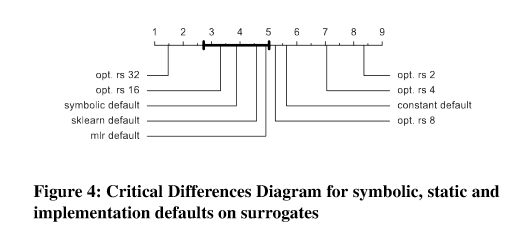

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
surrogate_performance = pd.read_csv("surrogate_performance.csv", sep=';', header=0)
opt_random_search = pd.read_csv("optimistic_random_search.csv", sep=';', header=0)
all_methods = pd.concat([surrogate_performance, opt_random_search])

In [5]:
def category_from_row(row):
    if '_' in row['optimizer']:
        return row['optimizer'].replace('_', ' ')
    elif row['optimizer'] == "mupluslambda":
        if row['constants']:
            return "constant default"
        else:
            return "symbolic default"
    else:
        raise ValueError(f"Unknown category for {row}")

all_methods["category"] = all_methods.apply(category_from_row, axis=1)

In [2]:
import Orange

In [21]:
learner = "svm"
learner_data = all_methods[all_methods.learner == learner].copy()
learner_data["optimizer_rank"] = learner_data.groupby("task").surrogate_score.rank(ascending=False)
n_tasks = learner_data.task.nunique()
names = learner_data.optimizer.unique()
average_rank_df = learner_data.groupby("category", as_index=False)["optimizer_rank"].mean()
critical_difference = Orange.evaluation.compute_CD(average_rank_df["optimizer_rank"], n_tasks)

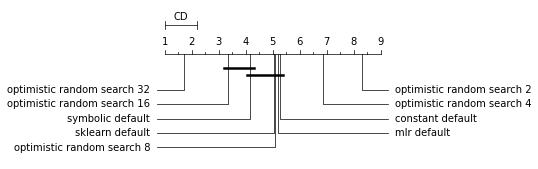

In [35]:
Orange.evaluation.graph_ranks(
    average_rank_df["optimizer_rank"],
    average_rank_df["category"],
    # cdmethod = (average_rank_df["category"] == "symbolic default").argmax(),
    cd=critical_difference,
    width=6,
    textspace=1.5
)

# Above new, below old

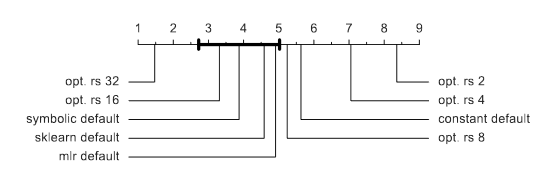

In [20]:
average_rank_df

,category,optimizer_rank
0,constant default,5.270
1,mlr default,5.195
2,optimistic random search 16,3.330
3,optimistic random search 2,8.320
4,optimistic random search 32,1.710
5,optimistic random search 4,6.870
6,optimistic random search 8,5.100
7,sklearn default,5.035
8,symbolic default,4.170


In [15]:
# learner_data.groupby("task").head(9).sort_values(by="task")[:19] looks good!

Original code:

In [ ]:
# Need to find out how to annotate those CD diagrams
aggsrdf2 = aggsrdf[~aggsrdf.search.isin(filter_search+["mupluslambda"])].copy()
aggsrdf2["out_rank"] = aggsrdf2.groupby(["task", "problem"]).out.rank(ascending=False)
aggsrdf2 = aggsrdf2.sort_values(["task", "problem"])
aggdf2 = aggsrdf2.groupby(["problem", "search"])["out_rank"].mean().reset_index()

for problem in aggdf2.problem.unique():
    data = aggdf2[aggdf2.problem == problem]
    if len(data):
        # Friedman Test: 
        cnts = aggsrdf2[aggsrdf2.problem == problem].groupby(["task"]).search.count()
        drop = cnts[cnts != cnts.max()].index.values
        ftestdata = aggsrdf2[(aggsrdf2.problem == problem) & (~aggsrdf2.task.isin(drop))]
        xar = [[x.values] for name, x in ftestdata.groupby(["search"])["out"]]
        tst = scipy.stats.friedmanchisquare(*xar)
        print(f"{problem} : {tst}")
        # Nemeny Test
        n_tasks = len(aggsrdf[aggsrdf.problem == problem].task.unique())
        print(f"{n_tasks}")
        names = data["search"].values
        avg_ranks = data["out_rank"].values
        cd = Orange.evaluation.compute_CD(avg_ranks, n_tasks)
        if tst[1] > 0.05:
            cd=None
        #import pdb; pdb.set_trace()
        cdm = [i for i,v in enumerate(names) if v == "symbolic default"]
        Orange.evaluation.graph_ranks(avg_ranks, names, cdmethod = cdm[0],cd=cd, width=6, textspace=1.5)
        # plt.title(problem)
        plt.savefig(f"figures/cd_surrogates_{problem}.pdf", bbox_inches='tight', pad_inches=.1)
        plt.show()